In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from datetime import datetime
import torch
import torch.nn as nn
from torch.autograd import Variable 
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

SAVE_PATH = '/Users/sangjinlee/Desktop/수위예측/data/lstm_models/'

# Data preprocessing

In [2]:
flood_data = pd.read_csv('/Users/sangjinlee/Desktop/수위예측/data/flood_data_20220926.csv')
flood_data.head(3)


,datetime,woojangchun_wl,suyoung_wl,suyoung_we_전운량,suyoung_we_상대습도(%),suyoung_we_해면기압(h㎩),suyoung_we_적설량(cm),suyoung_we_일사량(mj/㎡),suyoung_we_일조량(J),suyoung_we_기온(℃),...,oncheon2_actual_하늘상태,oncheon2_actual_rf,gupo_rf(mm),gupo_rf_cumulative_(mm),gupo_wl(m),gupo_wl_해발표고(EL.m),nakdonggang_inner_wl(m),nakdonggang_inner_wl_해발표고(EL.m),nakdonggang_outer_wl(m),nakdonggang_outer_wl_해발표고(EL.m)
0,2021-06-01 00:00:00,0.0,0.87,NaN,84,1013.5,NaN,NaN,NaN,17.4,...,-1.0,0.0,0.0,0.0,2.36,0.77,0.84,0.84,0.53,0.53
1,2021-06-01 00:01:00,0.0,0.87,NaN,84,1013.5,NaN,NaN,NaN,17.4,...,-1.0,0.0,0.0,0.0,2.36,0.77,0.84,0.84,0.53,0.53
2,2021-06-01 00:02:00,0.0,0.87,NaN,84,1013.5,NaN,NaN,NaN,17.4,...,-1.0,0.0,0.0,0.0,2.36,0.77,0.84,0.84,0.53,0.53


In [3]:
# 우장춘 수위 10분 단위로 데이터 변경: 1분 단위로 되어 있기 때문에 수작업으로 값을 넣어줌
# manually insert highest value when there's conflict within the same range of time aka different values in the same window
flood_data.loc[flood_data.datetime == '2021-06-16 14:00:00', 'woojangchun_wl'] = 4
flood_data.loc[flood_data.datetime == '2021-06-16 14:10:00', 'woojangchun_wl'] = 4
flood_data.loc[flood_data.datetime == '2021-06-16 14:40:00', 'woojangchun_wl'] = 4
flood_data.loc[flood_data.datetime == '2021-06-18 13:00:00', 'woojangchun_wl'] = 9
flood_data.loc[flood_data.datetime == '2021-06-18 13:10:00', 'woojangchun_wl'] = 12
flood_data.loc[flood_data.datetime == '2021-08-25 16:50:00', 'woojangchun_wl'] = 16
flood_data.loc[flood_data.datetime == '2021-08-25 17:00:00', 'woojangchun_wl'] = 8
flood_data.loc[flood_data.datetime == '2021-08-25 17:50:00', 'woojangchun_wl'] = 4

In [4]:
# 3 Targets - 10min, 30min, 60min

target_sensor = "woojangchun_wl"
features = list(flood_data.columns.difference([target_sensor]))

# 10, 30, 60분씩 앞으로 당기기
forecast_lead = [10,30,60]
for i in forecast_lead:
    target = f"{target_sensor}_lead{i}min"
    flood_data[target] = flood_data[target_sensor].shift(-i)

flood_data = flood_data.iloc[::10, :]
cols = ['datetime', 'woojangchun_wl', 'oncheon2_forecast_rf_1hr','oncheon2_forecast_rf_2hr',
        'oncheon2_forecast_rf_3hr', 'oncheon2_forecast_rf_4hr','oncheon2_forecast_rf_5hr',
        'oncheon2_forecast_rf_6hr', 'woojangchun_wl_lead10min', 'woojangchun_wl_lead30min',
        'woojangchun_wl_lead60min']

flood_data = flood_data[cols]
flood_data = flood_data.fillna(0)
flood_data


,datetime,woojangchun_wl,oncheon2_forecast_rf_1hr,oncheon2_forecast_rf_2hr,oncheon2_forecast_rf_3hr,oncheon2_forecast_rf_4hr,oncheon2_forecast_rf_5hr,oncheon2_forecast_rf_6hr,woojangchun_wl_lead10min,woojangchun_wl_lead30min,woojangchun_wl_lead60min
0,2021-06-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,2021-06-01 00:10:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,2021-06-01 00:20:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30,2021-06-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40,2021-06-01 00:40:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
132430,2021-08-31 23:10:00,0.0,0.1,0.0,0.2,0.5,2.5,6.3,0.0,0.0,0.0
132440,2021-08-31 23:20:00,0.0,0.1,0.0,0.2,0.5,2.5,6.3,0.0,0.0,0.0
132450,2021-08-31 23:30:00,0.0,0.1,0.0,0.2,0.5,2.5,6.3,0.0,0.0,0.0
132460,2021-08-31 23:40:00,0.0,0.1,0.0,0.2,0.5,2.5,6.3,0.0,0.0,0.0


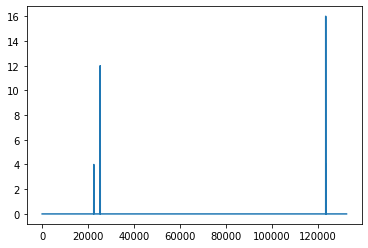

In [5]:
# 우장춘 데이터만 시각화 - 3개의 피크 확인
plt.plot(flood_data['woojangchun_wl'])
plt.show()

In [6]:
'''
train: 2021-06-01 00:00:00 ~ 2021-08-09 23:50:00
valid : 2021-08-10 00:00:00 ~ 2021-08-19 23:50:00
test: 2021-08-20 00:00:00 ~ 2021-08-31 23:50:00
'''
flood_data = flood_data.reset_index(drop=True)

# Train
split_train = flood_data.loc[pd.to_datetime(flood_data["datetime"]).dt.strftime('%Y-%m-%d')=="2021-08-10"]
split_train = split_train.iloc[:1,:].index[0]
train_set = flood_data[:split_train]

# valid
split_test = flood_data.loc[pd.to_datetime(flood_data["datetime"]).dt.strftime('%Y-%m-%d')=="2021-08-20"]
split_test = split_test.iloc[:1,:].index[0]
valid_set = flood_data[split_train:split_test]

# test
split_valid = flood_data.last_valid_index()
test_set = flood_data[split_test:]

print(split_train)
print(split_test)
print(split_valid)

10080
11520
13247


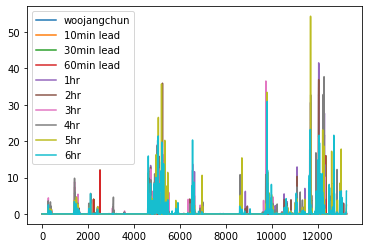

In [7]:
plt.plot(flood_data.reset_index()['woojangchun_wl'], label='woojangchun')
plt.plot(flood_data.reset_index()['woojangchun_wl_lead10min'], label='10min lead')
plt.plot(flood_data.reset_index()['woojangchun_wl_lead30min'], label='30min lead')
plt.plot(flood_data.reset_index()['woojangchun_wl_lead60min'], label='60min lead')
plt.plot(flood_data.reset_index()['oncheon2_forecast_rf_1hr'], label='1hr')
plt.plot(flood_data.reset_index()['oncheon2_forecast_rf_2hr'], label='2hr')
plt.plot(flood_data.reset_index()['oncheon2_forecast_rf_3hr'], label='3hr')
plt.plot(flood_data.reset_index()['oncheon2_forecast_rf_4hr'], label='4hr')
plt.plot(flood_data.reset_index()['oncheon2_forecast_rf_5hr'], label='5hr')
plt.plot(flood_data.reset_index()['oncheon2_forecast_rf_6hr'], label='6hr')
plt.legend(loc="upper left")
plt.show()

flood_data = flood_data[cols]

# Data Scaling

In [8]:
train_set.set_index("datetime", inplace = True)
test_set.set_index("datetime", inplace = True)
valid_set.set_index("datetime", inplace = True)

# Input scale
scaler_x = MinMaxScaler()
scaler_x.fit(train_set.iloc[:, :-3])

train_set.iloc[:, :-3] = scaler_x.transform(train_set.iloc[:, :-3])
test_set.iloc[:, :-3] = scaler_x.transform(test_set.iloc[:, :-3])
valid_set.iloc[:, :-3] = scaler_x.transform(valid_set.iloc[:, :-3])

# Output scale
scaler_y = MinMaxScaler()
scaler_y.fit(train_set.iloc[:, -3:])

train_set.iloc[:, -3:] = scaler_y.transform(train_set.iloc[:, -3:])
test_set.iloc[:, -3:] = scaler_y.transform(test_set.iloc[:, -3:])
valid_set.iloc[:, -3:] = scaler_y.transform(valid_set.iloc[:, -3:])


# Tensorizing data

In [9]:
from torch.utils.data import TensorDataset 
from torch.utils.data import DataLoader

# 6개의 데이터가 입력으로 들어간다
seq_length = 6
batch = 32

def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series)-seq_length):
        _x = time_series[i:i+seq_length, :-3]
        _y = time_series[i+seq_length, -3:]
#         print(_x, "-->",_y)
#         print()
        dataX.append(_x)
        dataY.append(_y)

    return np.array(dataX), np.array(dataY)

trainX, trainY = build_dataset(np.array(train_set), seq_length)
valX, valY = build_dataset(np.array(valid_set), seq_length)
testX, testY = build_dataset(np.array(test_set), seq_length)

trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)

valX_tensor = torch.FloatTensor(valX)
valY_tensor = torch.FloatTensor(valY)

testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

dataset = TensorDataset(trainX_tensor, trainY_tensor)
dataset_val = TensorDataset(valX_tensor, valY_tensor)

dataloader = DataLoader(dataset, batch_size=batch, shuffle=True, drop_last=True)
dataloader_val = DataLoader(dataset_val, batch_size=batch, shuffle=True, drop_last=True)



# Model

In [10]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes # number of classes
        self.num_layers = num_layers # number of layers
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # hidden state

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,num_layers=num_layers, batch_first=True) #lstm
        self.fc1 =  nn.Linear(hidden_size, 128) # fully connected 1
        self.fc2 = nn.Linear(128, num_classes) # fully connected last layer
        self.relu = nn.ReLU() 

    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) # hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) # internal state  
          
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # lstm with input, hidden, and internal state
   
        hn = hn.view(-1, self.hidden_size) # reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc1(out) # first Dense
        out = self.relu(out) # relu
        out = self.fc2(out) # Final Output
        out = self.relu(out) # relu
        
        return out

# Training

In [11]:
num_epochs = 100
learning_rate = 0.01

input_size = 7 #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 3 #number of output classes 

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

lstml = LSTM1(num_classes, input_size, hidden_size, num_layers).to(device)

mse = torch.nn.MSELoss()  # mean-squared error for regression
mae = torch.nn.L1Loss()  # mean absolute error

optimizer = torch.optim.Adam(lstml.parameters(), lr=learning_rate, weight_decay=0.9)


In [13]:
train_rmse_history = np.zeros(num_epochs)
train_mae_history = np.zeros(num_epochs)
val_rmse_history = np.zeros(num_epochs)
val_mae_history = np.zeros(num_epochs)

torch.autograd.set_detect_anomaly(True)

eps=1e-6

for epoch in range(num_epochs):
    lstml.train()
    tr_rmse_loss = 0.0
    tr_mae_loss = 0.0
    total_batch_ = len(dataloader)

    for batch_idx, samples in enumerate(dataloader):
        x_train, y_train = samples  
        optimizer.zero_grad() # caluclate the gradient, manually setting to 0
        outputs = lstml.forward(x_train.to(device)) # forward pass
        
        # loss
        rmse_ = torch.sqrt(mse(outputs, y_train.to(device)) + eps)
        mae_ = mae(outputs, y_train.to(device))
        
        rmse_.backward(retain_graph=True) # calculates the loss of the loss function
        mae_.backward(retain_graph=True)
    
        optimizer.step() # improve from loss, i.e backprop
        
        tr_rmse_loss += rmse_ / total_batch_
        tr_mae_loss += mae_ / total_batch_
        
    else:
        v_rmse_loss = 0.0
        v_mae_loss = 0.0
        total_batch = len(dataloader_val)
        avg_cost = 0
        
        lstml.eval()
        with torch.no_grad():
            for x_val, y_val in dataloader_val:
                val_outputs = lstml.forward(x_val.to(device)) # forward pass
                mae_ = mae(val_outputs, y_val.to(device))
                v_mae_loss += mae_ / total_batch
                v_rmse_loss += torch.sqrt(mse(val_outputs, y_val.to(device))) / total_batch
        
        train_rmse_history[epoch] = tr_rmse_loss
        train_mae_history[epoch] = tr_mae_loss
        val_rmse_history[epoch] = v_rmse_loss
        val_mae_history[epoch] = v_mae_loss
        
        # Early stopping
        if (epoch % 5 == 0) & (epoch != 0):
            if train_mae_history[epoch-3] < train_mae_history[epoch]:
                print('\n Early Stopping')
                break

        if epoch % 5 == 0:
            print(f'Epoch: {epoch}\nTraining RMSE Loss: {(tr_rmse_loss / len(dataloader)):.7f}\nTraining MAE Loss: {(tr_mae_loss / len(dataloader)):7f}\nValidation RMSE Loss: {(v_rmse_loss / len(dataloader_val)):.7f}\nValidation MAE Loss: {(v_mae_loss / len(dataloader_val)):.7f}\n')


    

Epoch: 0
Training RMSE Loss: 0.0000277
Training MAE Loss: 0.000018
Validation RMSE Loss: 0.0000205
Validation MAE Loss: 0.0000175

Epoch: 5
Training RMSE Loss: 0.0000103
Training MAE Loss: 0.000003
Validation RMSE Loss: 0.0000136
Validation MAE Loss: 0.0000121

Epoch: 10
Training RMSE Loss: 0.0000104
Training MAE Loss: 0.000003
Validation RMSE Loss: 0.0000132
Validation MAE Loss: 0.0000116

Epoch: 15
Training RMSE Loss: 0.0000105
Training MAE Loss: 0.000003
Validation RMSE Loss: 0.0000161
Validation MAE Loss: 0.0000140

Epoch: 20
Training RMSE Loss: 0.0000103
Training MAE Loss: 0.000003
Validation RMSE Loss: 0.0000119
Validation MAE Loss: 0.0000118

Epoch: 25
Training RMSE Loss: 0.0000107
Training MAE Loss: 0.000003
Validation RMSE Loss: 0.0000257
Validation MAE Loss: 0.0000255


 Early Stopping


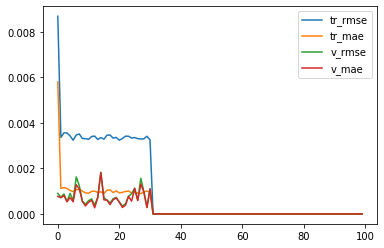

In [14]:
plt.plot(train_rmse_history, label='tr_rmse')
plt.plot(train_mae_history, label='tr_mae')
plt.plot(val_rmse_history, label='v_rmse')
plt.plot(val_mae_history, label='v_mae')
plt.legend()
plt.show()

# SAVE / LOAD MODEL

In [16]:
# SAVE MODEL  
PATH = SAVE_PATH + "woojangchun_lstm_20221023_final.pt"
torch.save(lstml.state_dict(), PATH)

# LOAD MODEL
lstml = LSTM1(num_classes, input_size, hidden_size, num_layers).to(device)
lstml.load_state_dict(torch.load(PATH), strict=False)
lstml.eval()

LSTM1(
  (lstm): LSTM(7, 2, batch_first=True)
  (fc1): Linear(in_features=2, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
  (relu): ReLU()
)

# Evaluation

In [17]:
with torch.no_grad(): 
    pred = []
    for pr in range(len(testX_tensor)):
        predicted = lstml(torch.unsqueeze(testX_tensor[pr], 0))
        predicted = predicted.squeeze(0)
        predicted = list(predicted.numpy())
        pred.append(predicted)
    pred_inverse = scaler_y.inverse_transform(np.array(pred).reshape(-1, 3))
    testY_inverse = scaler_y.inverse_transform(testY_tensor)

def MAE(true, pred):
    return np.mean(np.abs(true-pred))

def RMSE(pred, true):
    return np.sqrt(((pred - true) ** 2).mean())

print('MAE SCORE : {} / RMSE SCORE: {}'.format(MAE(pred_inverse, testY_inverse), RMSE(pred_inverse, testY_inverse)))

MAE SCORE : 0.029419714764685037 / RMSE SCORE: 0.44240832422143245


# Prediction Result

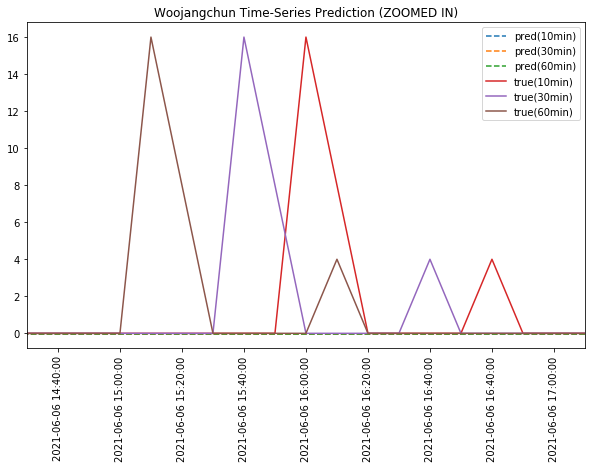

In [19]:
f, ax = plt.subplots(figsize=(10,6))
ax.plot(np.arange(len(pred_inverse)), pred_inverse[:,0], label = 'pred(10min)', linestyle='--')
ax.plot(np.arange(len(pred_inverse)), pred_inverse[:,1], label = 'pred(30min)', linestyle='--')
ax.plot(np.arange(len(pred_inverse)), pred_inverse[:,2], label = 'pred(60min)', linestyle='--')

ax.plot(np.arange(len(testY_inverse)), testY_inverse[:,0], label = 'true(10min)')
ax.plot(np.arange(len(testY_inverse)), testY_inverse[:,1], label = 'true(30min)')
ax.plot(np.arange(len(testY_inverse)), testY_inverse[:,2], label = 'true(60min)')
ax.legend()
labels = [flood_data.iloc[806,:].datetime, flood_data.iloc[808,:].datetime, 
          flood_data.iloc[810,:].datetime, flood_data.iloc[812,:].datetime, 
          flood_data.iloc[814,:].datetime, flood_data.iloc[816,:].datetime, 
          flood_data.iloc[818,:].datetime, flood_data.iloc[820,:].datetime, 
          flood_data.iloc[820,:].datetime, flood_data.iloc[822,:].datetime]
ax.set_xticklabels(labels)
plt.xticks(rotation=90)
plt.title("Woojangchun Time-Series Prediction (ZOOMED IN)")
plt.xlim(805, 823)
plt.show()

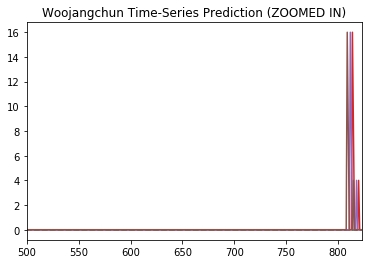

In [20]:
plt.plot(np.arange(len(pred_inverse)), pred_inverse[:,0], label = 'pred(10min)', linestyle='--')
plt.plot(np.arange(len(pred_inverse)), pred_inverse[:,1], label = 'pred(30min)', linestyle='--')
plt.plot(np.arange(len(pred_inverse)), pred_inverse[:,2], label = 'pred(60min)', linestyle='--')

plt.plot(np.arange(len(testY_inverse)), testY_inverse[:,0], label = 'true(10min)')
plt.plot(np.arange(len(testY_inverse)), testY_inverse[:,1], label = 'true(30min)')
plt.plot(np.arange(len(testY_inverse)), testY_inverse[:,2], label = 'true(60min)')
plt.xlim(500, 823)
plt.title("Woojangchun Time-Series Prediction (ZOOMED IN)")
plt.show()